In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Data generation function that calculates sum of evens and odds
def generate_data(N):
    X = torch.randint(0, 10, size=(N, 10))  # Generate random digits from 0 to 9
    evens = (X % 2 == 0).float() * X  # Mask and sum only even numbers
    odds = (X % 2 != 0).float() * X   # Mask and sum only odd numbers
    sum_evens = evens.sum(dim=-1)
    sum_odds = odds.sum(dim=-1)
    labels = (sum_evens > sum_odds)  # Label is 1 if sum of evens > sum of odds
    return X, labels.reshape(-1, 1).float()

X, y = generate_data(500)

In [3]:
# AttentionModel for the new task
class AttentionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.query = torch.nn.Parameter(torch.randn(1, 12))
        self.embed_func = torch.nn.Embedding(10, embedding_dim=12)
        self.key_func = torch.nn.Linear(12, 12)
        self.value_func = torch.nn.Sequential(
            torch.nn.Linear(12, 24),
            torch.nn.ReLU(),
            torch.nn.Linear(24, 1)
        )
        self.head_mlp = torch.nn.Sequential(
            torch.nn.Linear(1, 24),
            torch.nn.ReLU(),
            torch.nn.Linear(24, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, X):
        embedX = self.embed_func(X)  # Embed the input digits
        keys = self.key_func(embedX)  # Get keys from embeddings
        qk = torch.einsum('ie, bje->bij', self.query, keys)  # Compute query-key attention scores
        qk = qk / 12**0.5
        att = torch.nn.functional.softmax(qk, dim=-1)  # Attention scores
        vals = self.value_func(embedX)  # Get values from embeddings
        summary = torch.einsum('bij,bje->bie', att, vals)[:, 0, :]  # Apply attention to values
        pred = self.head_mlp(summary)  # Final prediction layer
        return pred, att, vals

In [4]:
# Training function for the task
def train():
    model = AttentionModel()
    opt = torch.optim.Adam(model.parameters(), lr=3e-4)
    losses = []
    for idx in range(5000):
        X, y = generate_data(123)  # Generate new batch of data
        p, a, v = model(X)
        loss = torch.nn.functional.binary_cross_entropy(p, y)  # Binary cross-entropy loss
        losses.append(float(loss))
        if idx % 100 == 0:
            print(float(loss))
            plt.plot(losses)
            plt.gcf().set_size_inches(2, 2)
            plt.show()
        loss.backward()
        opt.step()
        opt.zero_grad()
    return model

0.6874251365661621


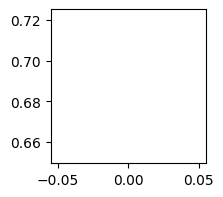

0.6770256757736206


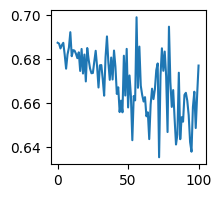

0.6117720007896423


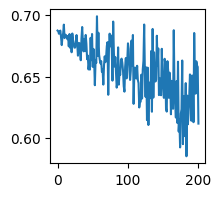

0.6244138479232788


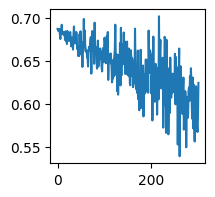

0.538387656211853


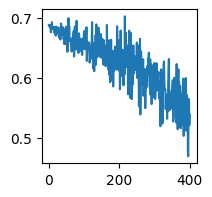

0.44801658391952515


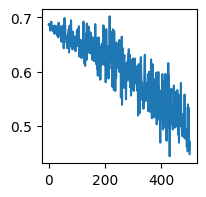

0.4073522984981537


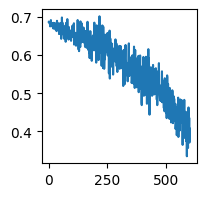

0.2876203954219818


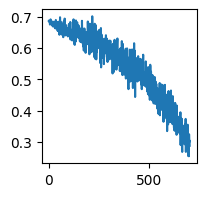

0.17535541951656342


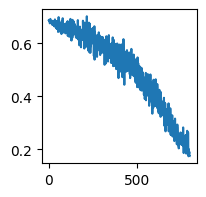

0.18010272085666656


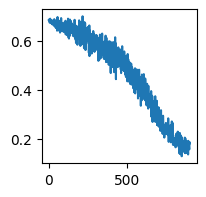

0.11162130534648895


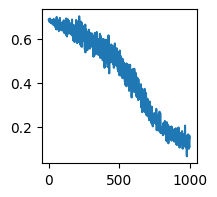

0.11743950098752975


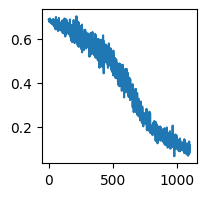

0.10010618716478348


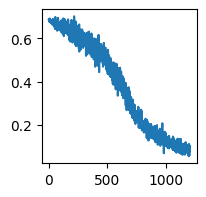

0.08479511737823486


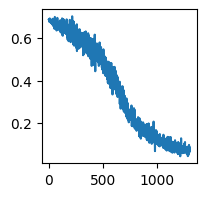

0.05319296196103096


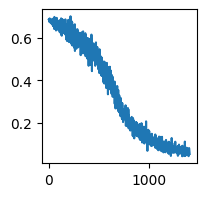

0.05927862599492073


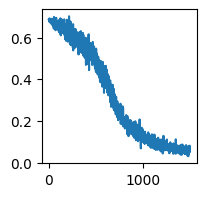

0.05298537015914917


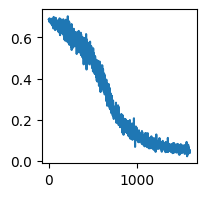

0.058800019323825836


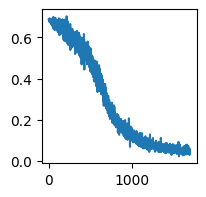

0.03942280262708664


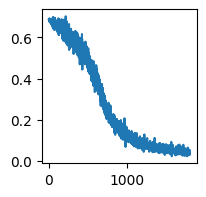

0.036842864006757736


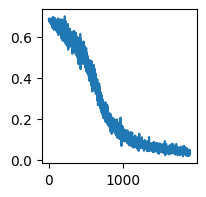

0.02628336101770401


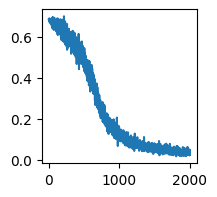

0.031717076897621155


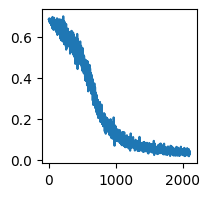

0.026131615042686462


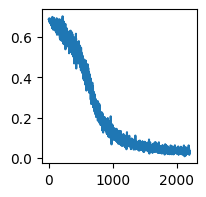

0.014335944317281246


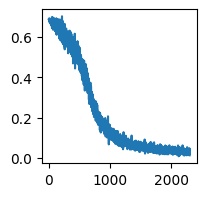

0.03458487242460251


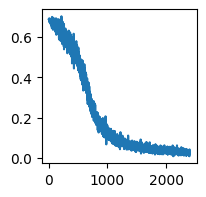

0.020439166575670242


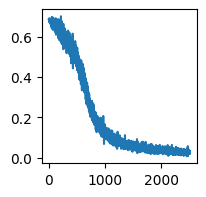

0.02007223851978779


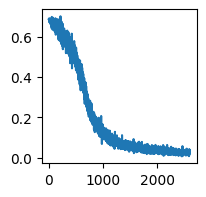

0.010163555853068829


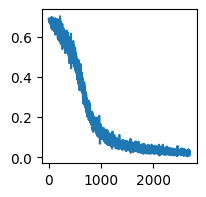

0.0190386101603508


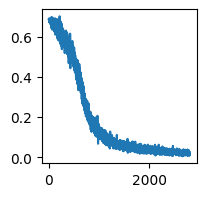

0.030448464676737785


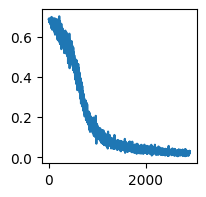

0.033933814615011215


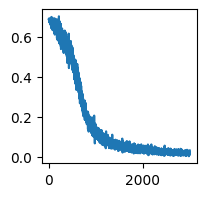

0.0139576131477952


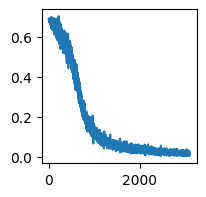

0.020595096051692963


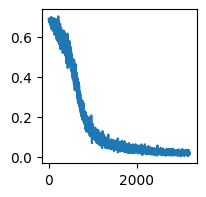

0.013742766343057156


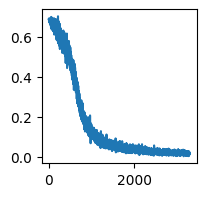

0.019744249060750008


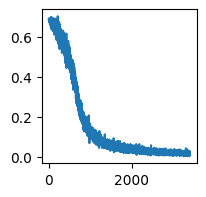

0.011161996982991695


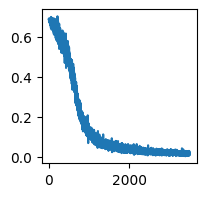

0.0030039052944630384


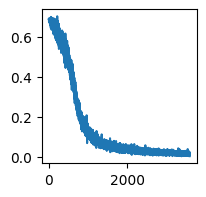

0.010003423318266869


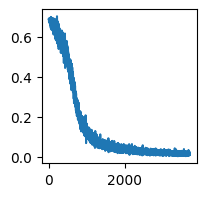

0.010867904871702194


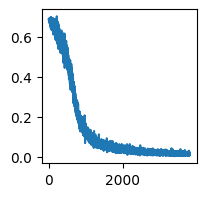

0.013968397863209248


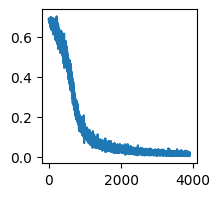

0.011965404264628887


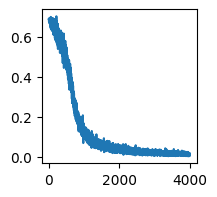

0.01320942584425211


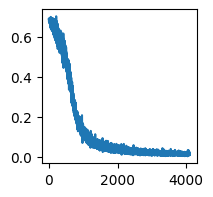

0.012472233735024929


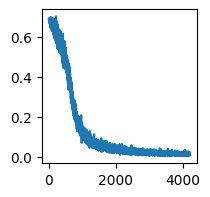

0.011953328736126423


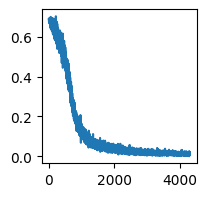

0.006797352340072393


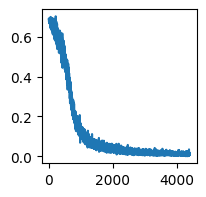

0.009316558949649334


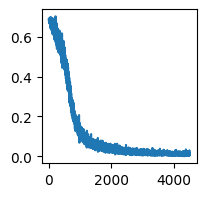

0.01155495923012495


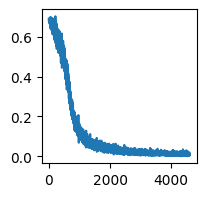

0.00966901145875454


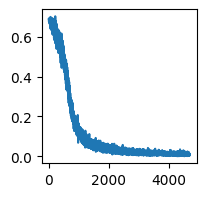

0.011855294927954674


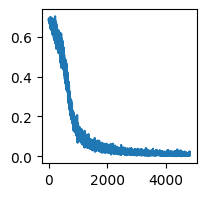

0.0018095221603289247


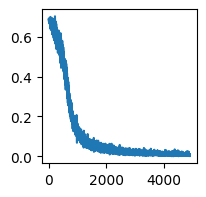

In [5]:
# Train and test the model
model = train()

In [6]:
# Testing the model with an example
with torch.no_grad():
    X_test = torch.LongTensor([[3, 6, 4, 9, 8, 1, 5, 7, 2, 0]])
    p, a, v = model(X_test)

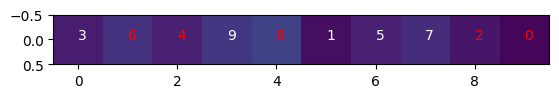

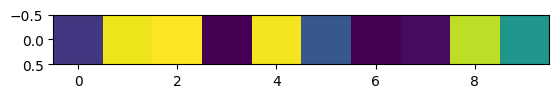

In [9]:
# Visualizing the attention and values
plt.imshow(a[0], vmin=0, vmax=1)
for x, y, d in zip(np.arange(10), np.zeros(10), X_test[0]):
    plt.text(x, y, int(d), c='r' if d % 2 == 0 else 'w')  # Color evens in red
plt.show()

# Visualize the value function outputs
plt.imshow(v[0].T)
plt.show()

In [12]:
# Show attention-applied messages for significant attention scores
msges = np.where(a[0] > 0.1, v[:, :, 0], np.nan * v[:, :, 0])
print(msges.shape, a[0].shape)

(1, 10) torch.Size([1, 10])
